In [1]:
import torch
from torch import nn


class MNISTAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, 9),
        )
        self.decoder = nn.Sequential(
            nn.Linear(9, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [3]:
from torchvision import datasets, transforms
from torch import optim

from net import AutoEncoder

EPOCHS = 20
BATCH_SIZE = 512

transform = transforms.Compose(
    [
        transforms.ToTensor(),  # (1, 28, 28)
        transforms.Lambda(lambda x: x.view(-1)),  # (28 * 28,)
    ]
)
train_dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)

model = MNISTAutoEncoder()
optimizer = optim.Adam(model.parameters(), lr=6e-3, weight_decay=1e-8)
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

autoencoder = AutoEncoder(
    model, optimizer, BATCH_SIZE, train_dataset, test_dataset, device
)

losses = []

for epoch in range(EPOCHS):
    losses += autoencoder.train(epoch)

Epoch #20: 100%|██████████| 118/118 [00:01<00:00, 68.18batch/s, Avg Loss=0.0288]


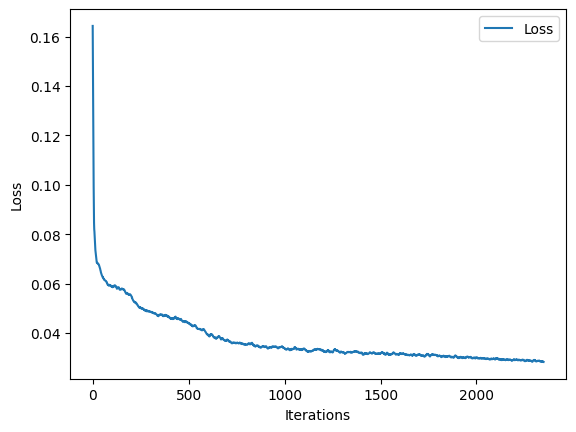

In [4]:
from net import plot_losses

fig, ax = plot_losses(losses, window=10)

In [5]:
import importlib
import net

import torch

importlib.reload(net)

torch.save(model.state_dict(), "models/ae.pt")
autoencoder = net.AutoEncoder(
    model, optimizer, BATCH_SIZE, train_dataset, test_dataset, device
)
autoencoder.model.load_state_dict(torch.load("models/ae.pt"))

<All keys matched successfully>

Test Set: 100%|██████████| 20/20 [00:00<00:00, 78.47batch/s, Avg Loss=0.0288]


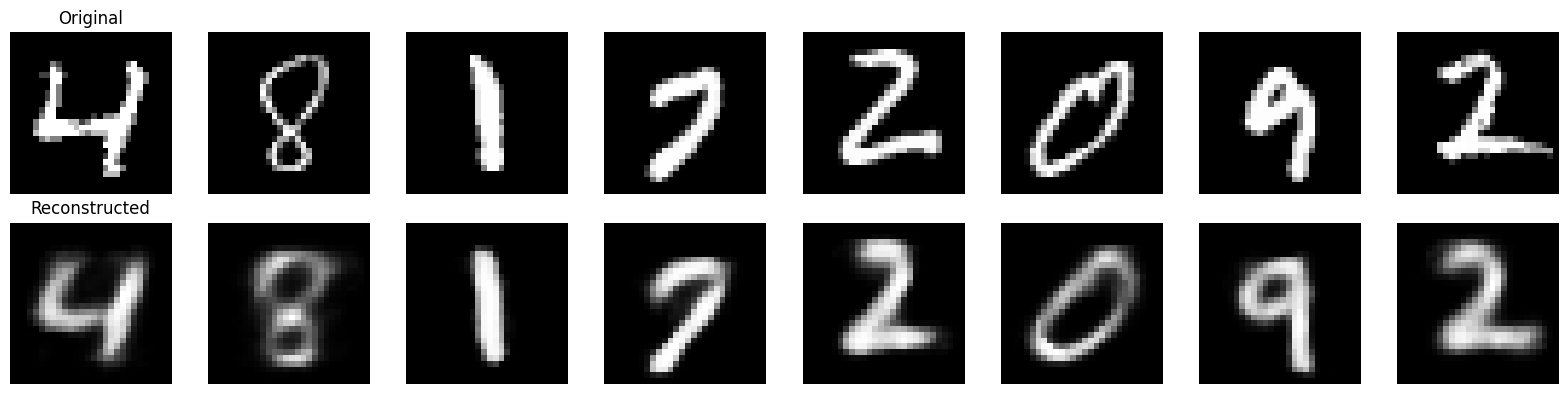

In [5]:
from matplotlib import pyplot as plt

losses = autoencoder.test()


def plot_comparison(images, reconstructed, n=8):
    fig = plt.figure(figsize=(n * 2, 4))

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i], cmap="gray")
        plt.axis("off")
        if i == 0:
            ax.set_title("Original")

    for i in range(n):
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i], cmap="gray")
        plt.axis("off")
        if i == 0:
            ax.set_title("Reconstructed")

    plt.tight_layout()
    return fig


images, reconstructed = autoencoder.get_batch()
fig = plot_comparison(
    images.view(-1, 28, 28).cpu().detach(),
    reconstructed.view(-1, 28, 28).cpu().detach(),
    n=8,
)

In [6]:
from torch import nn


class CIFARAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3 * 32 * 32, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 3 * 32 * 32),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


class CIFARConvAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 4x4
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

In [7]:
EPOCHS = 20
BATCH_SIZE = 512

transform = transforms.Compose(
    [
        transforms.ToTensor(),  # (3, 32, 32)
    ]
)
train_dataset = datasets.CIFAR10(
    root="./data", train=True, download=True, transform=transform
)
test_dataset = datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

model = CIFARConvAutoEncoder()
optimizer = optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-8)
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

cifar_autoencoder = AutoEncoder(
    model, optimizer, BATCH_SIZE, train_dataset, test_dataset, device
)

losses = []
for epoch in range(EPOCHS):
    losses += cifar_autoencoder.train(epoch)

Epoch #20: 100%|██████████| 98/98 [00:04<00:00, 19.62batch/s, Avg Loss=0.0022]


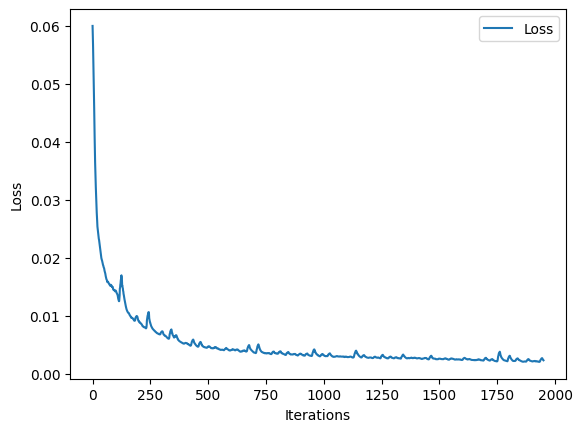

In [8]:
fig, ax = plot_losses(losses, window=10)

Test Set: 100%|██████████| 20/20 [00:00<00:00, 26.14batch/s, Avg Loss=0.0021]


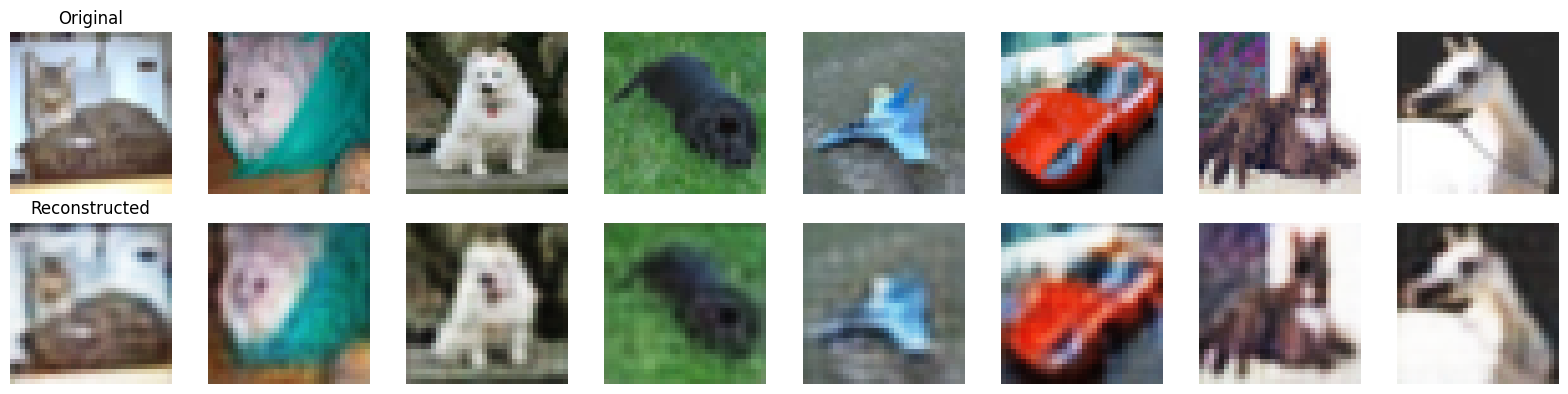

In [24]:
from matplotlib import pyplot as plt

losses = cifar_autoencoder.test()


def plot_comparison(images, reconstructed, n=8):
    fig = plt.figure(figsize=(n * 2, 4))

    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.axis("off")
        if i == 0:
            ax.set_title("Original")

    for i in range(n):
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].permute(1, 2, 0))
        plt.axis("off")
        if i == 0:
            ax.set_title("Reconstructed")

    plt.tight_layout()
    return fig


images, reconstructed = cifar_autoencoder.get_batch()
fig = plot_comparison(images.cpu().detach(), reconstructed.cpu().detach(), n=8)